In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import *

In [2]:
# the stakers where S[i] represents the total votes that the i-th staker has received, in AION.
S = [160, 80, 40, 30, 20, 10, 10, 10, 10, 10]
# in the NXT math paper, the balances are normalized; we do not do so to avoid a meaningless staking difficulty
#S = [x / sum(S) for x in S]
print("stakers:", S)

# the miners where M[i] represents the hash power of the i-th miner, in hashes/second.
M = [16, 8, 4, 3, 2, 1, 1, 1, 1, 1]
print("miners:", M)

stakers: [160, 80, 40, 30, 20, 10, 10, 10, 10, 10]
miners: [16, 8, 4, 3, 2, 1, 1, 1, 1, 1]


In [3]:
 -log(0.5) * 20

13.862943611198906

In [4]:
# number of iterations to run, in seconds
n = 30 * 24 * 60 * 60

# target block time, in seconds
t = 10

# the block chain
blocks = [] # (type, producer, timestamp, difficulty)

# the staking and mining target
target_s = 1
target_m = 1

# the timestamp of the last PoS block and PoW block
last_pos = -1
last_pow = -1

# the time delay of each staker
time_delay = []

# statistics: the block rewards of each staker and miner, blocks per second
rewards_s = np.zeros(len(S))
rewards_m = np.zeros(len(M))
forks = []

# returns a uniformly distributed value in [0, 1]
def u():
    return random.uniform(0, 1)

# Note: difficulty = 1 / target

# NXT target adjustment algorithm
def next_target_nxt(gamma, target, actual, expected):
    if actual >= 2 * expected:
        return target * 2
    elif actual >= 1 * expected:
        return target * actual / expected
    elif actual >= 0.5 * expected:
        return target - target * gamma * (expected - actual) / expected
    else:
        return target - target * gamma * 0.5

# Aion target adjustment algorithm
def next_target_aion(alpha, target, actual, expected):
    bar = -log(0.5) * expected
    if actual >= bar:
        return target * (1 + alpha)
    else:
        return target / (1 + alpha)

# simulate the block generation process, second-by-second
for i in range(n):
    
    # TODO: fine-tune the target adjustment algorithm
    aion_target_adj = True
    gamma = 1
    alpha = 0.01
    
    # TODO: fine-tune the logarithmic fix
    logarithmic_fix = False
    c0 = 0 
    c1 = 5
    c2 = 1
    
    # compute the time delay for every staker, if haven't done so
    if len(time_delay) == 0:
        for j in range(len(S)):
            d = abs(log(u())) / (target_s * S[j])
            if logarithmic_fix:
                d = c0 + c1 * log(1 + c2 * d)
            d = ceil(d)
            time_delay.append(d)
        #print("time delay:", time_delay)
    
    # print trace info
    if i % (12 * 60 * 60) == 0:
        print(i, target_s, target_m, time_delay)

    # check if any staker(s) is eligible to produce a block
    time_delay_min = min(time_delay)
    stakers = [j for j, x in enumerate(time_delay) if x == time_delay_min]
    if i - last_pos < time_delay_min:
        stakers = []
    
    # check if any miner(s) is able to find a solution
    miners = []
    for j in range(len(M)):
        for k in range(M[j]):
            if u() <= target_m:
                # a block is found by the j-th miner
                miners.append(j)
                break
    
    # update the stats
    forks.append(len(stakers) + len(miners))
    
    # neither the stakers nor the miners managed to produce a block
    if len(stakers) + len(miners) == 0:
        continue
    
    # now, they have to fight
    f = random.randint(0, len(stakers) + len(miners) - 1)
    if f < len(stakers):
        # append a PoS block
        staker = stakers[f]
        blocks.append(('s', staker, i, 1 / target_s))
        rewards_s[staker] += 1
        #print("forged by", staker, i)
        
        # adjust the staking target
        actual = i - last_pos - 0.5 # -0.5 to compensate accuracy loss
        expected = 2 * t
        if aion_target_adj:
            target_s = next_target_aion(alpha, target_s, actual, expected)
        else:
            target_s = next_target_nxt(gamma, target_s, actual, expected)
            
        # update the state
        last_pos = i
        time_delay = []
    else:
        # append a PoW block
        miner = miners[f - len(stakers)]
        blocks.append(('m', miner, i, 1 / target_m))
        rewards_m[miner] += 1
        #print("mined by", miner, i)
        
        # adjust the mining target
        actual = i - last_pow - 0.5
        expected = 2 * t
        if aion_target_adj:
            target_m = next_target_aion(alpha, target_m, actual, expected)
        else:
            target_m = next_target_nxt(gamma, target_m, actual, expected)
            
        # update the state
        last_pow = i

print("Done!")

0 1 1 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
43200 0.00013563459175056813 0.0012229088009172576 [82, 63, 250, 779, 287, 63, 1084, 1505, 99, 107]
86400 0.00013974445551520208 0.001337477345399296 [29, 144, 34, 389, 199, 2512, 491, 3563, 985, 45]
129600 0.0001316455984712896 0.0012229088009172576 [58, 59, 96, 302, 369, 419, 92, 399, 530, 257]
172800 0.0001342916750005625 0.0011988126663241424 [16, 261, 30, 835, 247, 555, 124, 98, 1219, 184]
216000 0.0001316455984712896 0.001350852118853289 [32, 73, 194, 63, 135, 64, 853, 976, 401, 635]
259200 0.00011339286710671294 0.001337477345399296 [137, 104, 315, 38, 714, 515, 1198, 759, 615, 2207]
302400 0.00012157250150187907 0.001350852118853289 [113, 270, 157, 67, 789, 1389, 2018, 1460, 3433, 919]
345600 0.00013974445551520208 0.0013111237578661856 [50, 329, 73, 533, 104, 996, 253, 2308, 351, 580]
388800 0.00011115857965563468 0.0015527696765192597 [42, 22, 79, 1070, 871, 1959, 721, 634, 761, 473]
432000 0.00013296205445600248 0.0011988126663241424 [41,

In [5]:
print("last 20 blocks:", blocks[-20:])
print("staker rewards:", rewards_s, sum(rewards_s))
print("miner rewards:", rewards_m, sum(rewards_m))
print("staking target:", target_s)
print("mining target:", target_m)

timestamps = [x[2] for i, x in enumerate(blocks)]
block_time = np.subtract(timestamps[1:], timestamps[:-1])
print("block time (last 10):", block_time[-10:])
print("block time mean:", np.mean(block_time))
print("block time std:", np.std(block_time))

pos_timestamps = [x[2] for i, x in enumerate(blocks) if x[0] == 's']
pos_block_time = np.subtract(pos_timestamps[1:], pos_timestamps[:-1])
print("PoS block time (last 10):", pos_block_time[-10:])
print("PoS block time mean:", np.mean(pos_block_time))
print("PoS block time std:", np.std(pos_block_time))

pow_timestamps = [x[2] for i, x in enumerate(blocks) if x[0] == 'm']
pow_block_time = np.subtract(pow_timestamps[1:], pow_timestamps[:-1])
print("PoW block time (last 10):", pow_block_time[-10:])
print("PoW block time mean:", np.mean(pow_block_time))
print("PoW block time std:", np.std(pow_block_time))

last 20 blocks: [('s', 0, 2591846, 6608.371109090988), ('m', 0, 2591860, 817.7224656899499), ('m', 0, 2591861, 809.6262036534158), ('m', 8, 2591863, 817.7224656899499), ('m', 5, 2591864, 825.8996903468494), ('s', 1, 2591870, 6542.9416921692955), ('m', 1, 2591876, 834.1586872503179), ('s', 0, 2591904, 6478.160091256728), ('s', 8, 2591905, 6414.019892333394), ('m', 2, 2591918, 842.5002741228211), ('m', 1, 2591934, 834.1586872503179), ('m', 0, 2591940, 825.8996903468494), ('s', 1, 2591954, 6478.160091256728), ('s', 2, 2591960, 6414.019892333394), ('m', 1, 2591968, 834.1586872503179), ('s', 9, 2591971, 6478.160091256728), ('s', 6, 2591975, 6542.9416921692955), ('s', 4, 2591987, 6608.371109090988), ('s', 1, 2591994, 6674.454820181899), ('m', 0, 2591999, 825.8996903468494)]
staker rewards: [52380. 26134. 13342.  9947.  6612.  3313.  3387.  3200.  3315.  3228.] 124858.0
miner rewards: [52786. 26290. 13118.  9942.  6560.  3295.  3259.  3361.  3284.  3291.] 125186.0
staking target: 0.0001483415

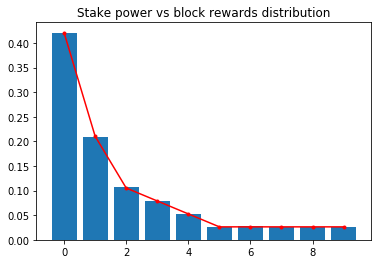

In [6]:
plt.bar(range(len(S)), rewards_s / sum(rewards_s));
plt.plot(range(len(S)), np.divide(S, sum(S)), color="r", marker=".");
plt.title("Stake power vs block rewards distribution");
plt.savefig("stake-power-vs-rewards.pdf")

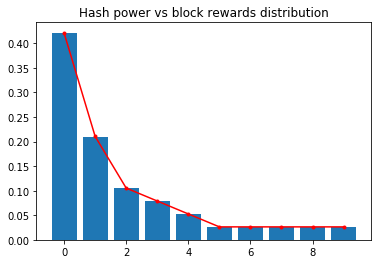

In [7]:
plt.bar(range(len(M)), rewards_m / sum(rewards_m));
plt.plot(range(len(M)), np.divide(M, sum(M)), color="r", marker=".");
plt.title("Hash power vs block rewards distribution");
plt.savefig("hash-power-vs-rewards.pdf")

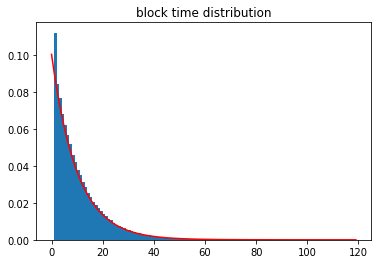

In [8]:
plt.hist(block_time, bins=range(120), density=1);
plt.title("block time distribution");

# the PDF of Exp(\lambda)
def pdf(l, x):
    return l * pow(e, -l * x)

pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 's']
pow_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 'm']

x = range(120)
y = np.vectorize(pdf)(sum(S) / np.mean(pos_diff) + sum(M) / np.mean(pow_diff), x)
plt.plot(x, y, color="red");

plt.savefig("block-time.pdf");

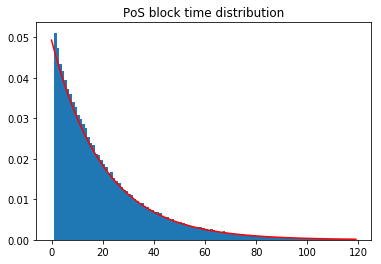

In [9]:
plt.hist(pos_block_time, bins=range(120), density=1);
plt.title("PoS block time distribution");

x = range(120)
y = np.vectorize(pdf)(sum(S)  / np.mean(pos_diff), x)
plt.plot(x, y, color="red");

plt.savefig("pos-block-time.pdf");

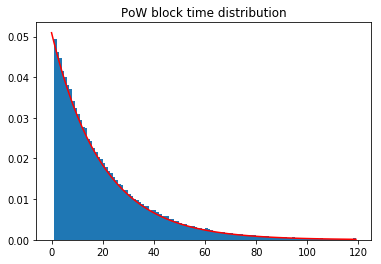

In [10]:
plt.hist(pow_block_time, bins=range(120), density=1);
plt.title("PoW block time distribution");

x = range(120)
y = np.vectorize(pdf)(sum(M)  / np.mean(pow_diff), x)
plt.plot(x, y, color="red");

plt.savefig("pow-block-time.pdf");

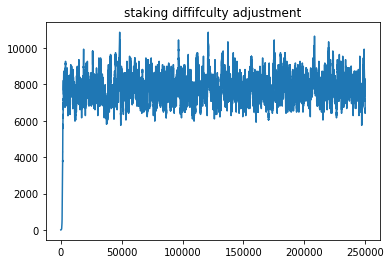

In [11]:
pos_number = [i for i, x in enumerate(blocks) if x[0] == 's']
pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 's']
plt.plot(pos_number, pos_diff);
plt.title("staking diffifculty adjustment");
plt.savefig("pos-diff.pdf")

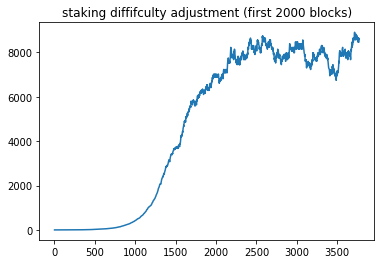

In [12]:
pos_number = [i for i, x in enumerate(blocks) if x[0] == 's']
pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 's']
interval = 2000;
plt.plot(pos_number[:interval], pos_diff[:interval]);
plt.title("staking diffifculty adjustment (first " + str(interval) + " blocks)");
plt.savefig("pos-diff-head.pdf")

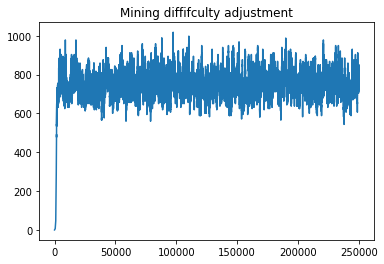

In [13]:
pos_number = [i for i, x in enumerate(blocks) if x[0] == 'm']
pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 'm']
plt.plot(pos_number, pos_diff);
plt.title("Mining diffifculty adjustment");
plt.savefig("pow-diff.pdf")

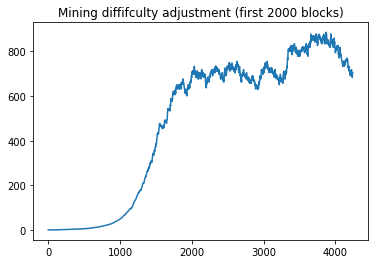

In [14]:
pos_number = [i for i, x in enumerate(blocks) if x[0] == 'm']
pos_diff = [x[3] for i, x in enumerate(blocks) if x[0] == 'm']
interval = 2000;
plt.plot(pos_number[:interval], pos_diff[:interval]);
plt.title("Mining diffifculty adjustment (first " + str(interval) + " blocks)");
plt.savefig("pow-diff-head.pdf")

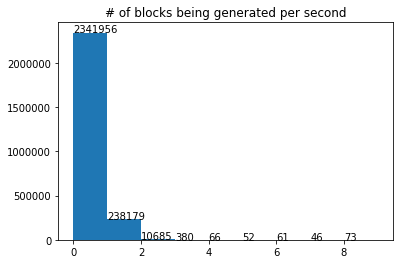

In [15]:
arr = plt.hist(forks, bins=range(10));
for i in range(9):
    plt.text(arr[1][i], arr[0][i] + 800, str(int(arr[0][i])))
plt.title("# of blocks being generated per second")
plt.savefig("forks.pdf")

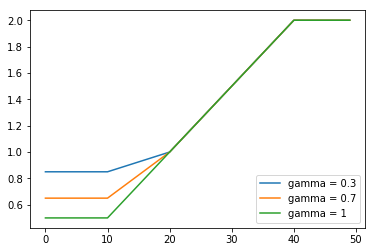

In [16]:
actual = range(0, 50, 1)
expected = 20

next_targets = np.vectorize(next_target_nxt)(0.3, 1, actual, expected)
plt.plot(actual, next_targets, label=("gamma = 0.3"));

next_targets = np.vectorize(next_target_nxt)(0.7, 1, actual, expected)
plt.plot(actual, next_targets, label=("gamma = 0.7"));

next_targets = np.vectorize(next_target_nxt)(1, 1, actual, expected)
plt.plot(actual, next_targets, label=("gamma = 1"));

plt.legend(loc='lower right')
plt.savefig("gamma.pdf")

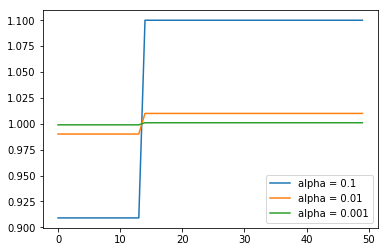

In [17]:
actual = range(0, 50, 1)
expected = 20

next_targets = np.vectorize(next_target_aion)(0.1, 1, actual, expected)
plt.plot(actual, next_targets, label=("alpha = 0.1"));

next_targets = np.vectorize(next_target_aion)(0.01, 1, actual, expected)
plt.plot(actual, next_targets, label=("alpha = 0.01"));

next_targets = np.vectorize(next_target_aion)(0.001, 1, actual, expected)
plt.plot(actual, next_targets, label=("alpha = 0.001"));

plt.legend(loc='lower right')
plt.savefig("alpha.pdf")